In [1]:
import matplotlib as mpl
mpl.use("pgf")

## TeX preamble
pgf_with_pdflatex = {
    "font.family": "serif",
    "text.usetex": True,
    "text.latex.unicode": True,
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": [
         r"\usepackage[utf8x]{inputenc}",
         r"\usepackage[T1]{fontenc}",
         r"\usepackage[]{libertine}"
         r"\usepackage[libertine]{newtxmath}"
         ]
}
mpl.rcParams.update(pgf_with_pdflatex)

mpl.rcParams['font.family'] = 'Libertine'

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Linux Libertine']})

import matplotlib.font_manager as fm
prop = fm.FontProperties(fname='/usr/local/texlive/2017/texmf-dist/fonts/opentype/public/libertine/LinLibertine_DR.otf')

In [2]:
import numpy as np
from matplotlib import pyplot as plt
plt.rc('text',usetex=True)
plt.rc('figure',figsize=(5.05,3.1),dpi=100)
plt.rc('text.latex',preamble=[r'\usepackage[]{libertine}',r'\usepackage[libertine]{newtxmath}'])
%matplotlib inline

In [343]:
A = 0.1
eps = 0.1
w = 2*np.pi/10

def vel(t,x):
    f = eps*np.sin(w*t)*x.T[0]**2 + (1-2*eps*np.sin(w*t))*x.T[0]
    dfdx = 2*eps*np.sin(w*t)*x.T[0]+ (1-2*eps*np.sin(w*t))
    return np.pi*A*np.array([-np.sin(np.pi*f)*np.cos(np.pi*x.T[1]),np.cos(np.pi*f)*np.sin(np.pi*x.T[1])*dfdx]).T

def jac_vel(t,x):
    f = eps*np.sin(w*t)*x.T[0]**2 + (1-2*eps*np.sin(w*t))*x.T[0]
    dfdx = 2*eps*np.sin(w*t)*x.T[0]+ (1-2*eps*np.sin(w*t))
    d2fdx2 = 2*eps*np.sin(w*t)
    return np.pi*A*np.array([[-np.cos(np.pi*f)*np.pi*dfdx*np.cos(np.pi*x.T[1]),np.sin(np.pi*f)*np.pi*np.sin(np.pi*x.T[1])],
                             [-np.sin(np.pi*f)*np.pi*dfdx*np.sin(np.pi*x.T[1])*dfdx + np.cos(np.pi*f)*np.pi*np.sin(np.pi*x.T[1])*d2fdx2,np.cos(np.pi*f)*np.pi*np.cos(np.pi*x.T[1])*dfdx]]).transpose(3,2,0,1)

In [448]:
xmin,xmax = 0,2
ymin,ymax = 0,1

nx = 200
ny = 100

x,dx = np.linspace(xmin,xmax,nx,retstep=True)
y,dy = np.linspace(ymin,ymax,ny,retstep=True)

def makegrid(x,y):
    return np.array(np.meshgrid(x,y,indexing='ij')).transpose(1,2,0)

def initialjacobian(x,y):
    q = []
    for k in range(x.size):
        q.append(np.asarray([np.eye(2,dtype=np.float64) for j in range(y.size)]))
    return np.asarray(q)

def get_evals(t0,x,y,tf,h,f):
    g = makegrid(x,y)
    jac = initialjacobian(x,y)
    for j in range(np.ceil((tf-t0)/h).astype(int)):
        k1 = f(t0+j*h,g)
        jv = jac_vel(t0+j*h,g)
        k1_j = np.zeros(jac.shape)
        k2_j = np.zeros(jac.shape)
        for q in range(2):
            for l in range(2):
                for k in range(2):
                    k1_j[:,:,q,l] += jv[:,:,q,k]*jac[:,:,k,l]
        #k1_j[:,:,0,0] = jv[:,:,0,0]*jac[:,:,0,0] + jv[:,:,0,1]*jac[:,:,1,0]
        #k1_j[:,:,0,1] = jv[:,:,0,0]*jac[:,:,0,1] + jv[:,:,0,1]*jac[:,:,1,1]
        #k1_j[:,:,1,0] = jv[:,:,1,0]*jac[:,:,0,0] + jv[:,:,1,1]*jac[:,:,1,0]
        #k1_j[:,:,1,1] = jv[:,:,1,0]*jac[:,:,0,1] + jv[:,:,1,1]*jac[:,:,1,1]
        k2 = f(t0+(j+1)*h,g+k1*h)
        jv = jac_vel(t0+(j+1)*h,g+k1*h)
        for q in range(2):
            for l in range(2):
                for k in range(2):
                    k2_j[:,:,q,l] += jv[:,:,q,k]*(jac[:,:,k,l]+h*k1_j[:,:,k,l])
        #k2_j[:,:,0,0] = jv[:,:,0,0]*(jac[:,:,0,0]+k1_j[:,:,0,0]*h) + jv[:,:,0,1]*(jac[:,:,1,0]+k1_j[:,:,1,0]*h)
        #k2_j[:,:,0,1] = jv[:,:,0,0]*(jac[:,:,0,1]+k1_j[:,:,0,1]*h) + jv[:,:,0,1]*(jac[:,:,1,1]+k1_j[:,:,1,1]*h)
        #k2_j[:,:,1,0] = jv[:,:,1,0]*(jac[:,:,0,0]+k1_j[:,:,0,0]*h) + jv[:,:,1,1]*(jac[:,:,1,0]+k1_j[:,:,1,0]*h)
        #k2_j[:,:,1,1] = jv[:,:,1,0]*(jac[:,:,0,1]+k1_j[:,:,0,1]*h) + jv[:,:,1,1]*(jac[:,:,1,1]+k1_j[:,:,1,1]*h)
        g = g + (k1+k2)*h/2.
        jac = jac + (k1_j+k2_j)*h/2.
    #u,s,v = np.linalg.svd(jac)
    return jac
    #return g,s**2,v.transpose(0,1,3,2)

def _rk2_advection(t0,x,y,tf,h,f):
    g = makegrid(x,y)
    for j in range(np.ceil((tf-t0)/h).astype(int)):
        k1 = f(t0+j*h,g)
        k2 = f(t0+(j+1)*h,g+k1*h)
        g = g + (k1+k2)*h/2.
    return g
    
    

In [451]:
%timeit _rk2_advection(0,x,y,20,0.01,vel)

12.4 s ± 282 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [456]:
%timeit get_evals(0,x,y,20,0.05,vel)

10 s ± 534 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [358]:
#gf,vals,vecs = get_evals(0,x,y,20,0.01,vel)
jac = get_evals(0,x,y,20,0.1,vel)


In [389]:
bals

array([[ 15.        ,  15.        ,  15.        , ...,  15.        ,
         15.        ,  15.        ],
       [ 15.        ,   7.54781163,   8.67146359, ...,  15.        ,
          9.44083443,  15.        ],
       [ 15.        ,   9.42168805,   8.18166272, ...,   8.42513528,
         15.        ,  15.        ],
       ..., 
       [ 15.        ,   8.23355352,   8.8911909 , ...,   4.78747434,
          8.28892006,  15.        ],
       [ 15.        ,   9.13753902,   6.71691247, ...,   9.96986419,
         15.        ,  15.        ],
       [ 15.        ,  15.        ,  15.        , ...,  15.        ,
         15.        ,  15.        ]])

In [387]:
s = np.linalg.svd(jac,compute_uv=False)

In [359]:
vals,vecs = np.linalg.eigh(np.matmul(jac.transpose(0,1,3,2),jac))

In [416]:
g = makegrid(x,y)
jv = jac_vel(0,g)

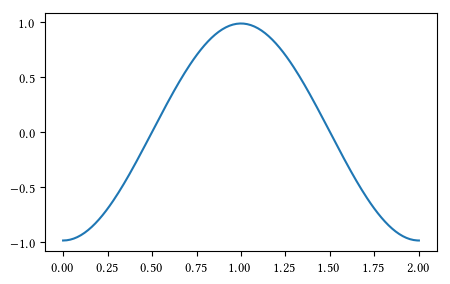

In [417]:
plt.plot(x,jv[:,0,0,0])

In [290]:
jacs = np.empty((*gf.shape[:2],2,2))
jacs[1:-1,:,0,0] = (gf[2:,:,0]-gf[:-2,:,0])/(2*dx)
jacs[:,1:-1,0,1] = (gf[:,2:,0]-gf[:,:-2,0])/(2*dy)
jacs[1:-1,:,1,0] = (gf[2:,:,1]-gf[:-2,:,1])/(2*dx)
jacs[:,1:-1,1,1] = (gf[:,2:,1]-gf[:,:-2,1])/(2*dy)
tens = np.matmul(jacs[1:-1,1:-1].transpose(0,1,3,2),jacs[1:-1,1:-1])
evals,evecs = np.linalg.eigh(tens)

In [325]:
jac_vel(0,g).shape

(100, 50, 2, 2)

In [118]:
g = makegrid(x,y)

In [121]:
vel(0,g).shape

(100, 50, 2)

In [304]:
jac_vel(0,g).shape

(2, 2, 50, 100)

In [73]:
a = np.empty(*jac_vel(0,g).shape)

TypeError: data type not understood

In [116]:
np.array(np.meshgrid(x,y,indexing='ij')).transpose(1,2,0).shape

(100, 50, 2)

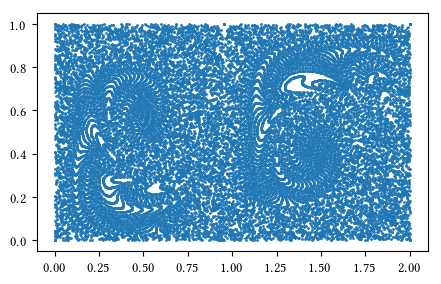

In [196]:
plt.scatter(gf[:,:,0],gf[:,:,1],s=1)

In [352]:
np.min(vals[:,:,0])

0.0

In [110]:
np.array(np.meshgrid(x,y,indexing='ij')).shape

(2, 100, 50)

In [395]:
bals[bals>8] = 8

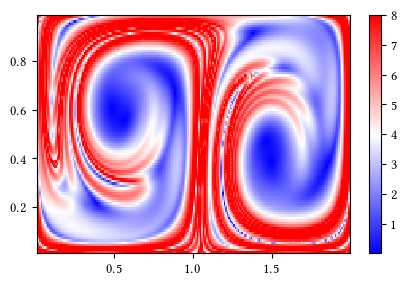

In [396]:
X,Y = np.meshgrid(x,y,indexing='ij')
plt.pcolormesh(X[1:-1,1:-1],Y[1:-1,1:-1],(bals[1:-1,1:-1]),cmap='bwr')
plt.colorbar()
#plt.pcolormesh(X[1:-1,1:-1],Y[1:-1,1:-1],np.log(vals[1:-1,1:-1,1]**2+vals[1:-1,1:-1,0]**2),cmap='bwr')

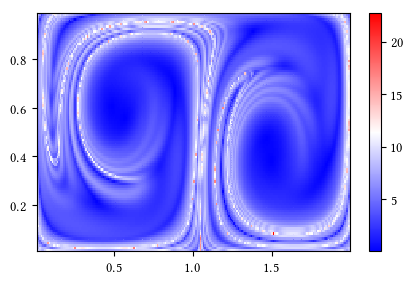

In [388]:
X,Y = np.meshgrid(x,y,indexing='ij')
plt.pcolormesh(X[1:-1,1:-1],Y[1:-1,1:-1],np.log(s[1:-1,1:-1,0]**2),cmap='bwr')
plt.colorbar()
#plt.pcolormesh(X[1:-1,1:-1],Y[1:-1,1:-1],np.log(vals[1:-1,1:-1,1]**2+vals[1:-1,1:-1,0]**2),cmap='bwr')

In [379]:
idx = np.greater_equal(np.log(vals[:,:,1]),10)

In [380]:
idx.shape

(200, 100)

In [381]:
bals = np.log(vals[:,:,1])
bals[idx] = 15

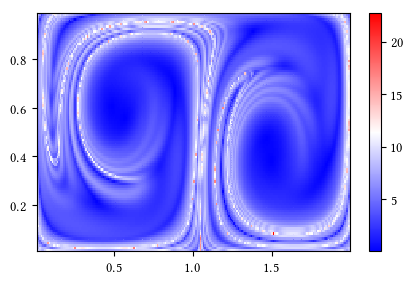

In [386]:
X,Y = np.meshgrid(x,y,indexing='ij')
plt.pcolormesh(X[1:-1,1:-1],Y[1:-1,1:-1],np.log(vals[1:-1,1:-1,1]),cmap='bwr')
plt.colorbar()
#plt.pcolormesh(X[1:-1,1:-1],Y[1:-1,1:-1],np.log(vals[1:-1,1:-1,1]**2+vals[1:-1,1:-1,0]**2),cmap='bwr')

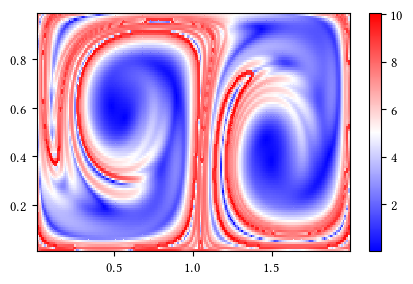

In [361]:
X,Y = np.meshgrid(x,y,indexing='ij')
plt.pcolormesh(X[1:-1,1:-1],Y[1:-1,1:-1],np.log(evals[:,:,1]),cmap='bwr')
plt.colorbar()

In [237]:
X.shape


(200,)

In [156]:
vals[-3,:,0]

array([  1.00003698,  15.39903289,  11.55454112,   6.36125353,
         4.82256501,   5.02791825,   5.98289829,   6.96073179,
         7.02228269,   5.98976505,   4.74124082,   3.80496144,
         3.22805376,   2.93743603,   2.8601125 ,   2.93589975,
         3.11347332,   3.34914344,   3.60778935,   3.86341113,
         4.09854639,   4.30282937,   4.47113543,   4.60163345,
         4.69393472,   4.74745404,   4.76009407,   4.72741603,
         4.642562  ,   4.49733946,   4.28502601,   4.00538598,
         3.67156375,   3.31641053,   2.99423988,   2.78120104,
         2.81700917,   3.82729288,   9.39586978,   4.99692072,
         5.93429593,   8.58631237,  11.51150772,  13.74772775,
        15.42707398,  16.9452151 ,  18.58531065,  20.45407071,
        22.48676489,  24.50230376,  26.29821673,  27.72996343,
        28.73602449,  29.32175727,  29.53235008,  29.43149093,
        29.08824584,  28.56960632,  27.93620984,  27.23987496,
        26.52239486,  25.81535695,  25.14079851,  24.51

In [173]:
evals[0,0]

array([  688.10191483,  4232.74561818])

In [209]:
vals[100]

array([[  1.92813290e+00,   4.88689519e-03],
       [  4.31783279e+00,   4.33239888e-01],
       [  4.12722945e+00,   2.76516552e-01],
       [  3.26597124e+00,   2.47172766e-01],
       [  2.60368390e+00,   2.77613872e-01],
       [  2.30042590e+00,   3.35425263e-01],
       [  2.21166692e+00,   3.97880108e-01],
       [  2.22591719e+00,   4.59575289e-01],
       [  2.21203459e+00,   5.22260849e-01],
       [  2.05906818e+00,   5.65427136e-01],
       [  1.88938826e+00,   5.63704343e-01],
       [  1.85849600e+00,   5.26271025e-01],
       [  1.97009585e+00,   4.76714583e-01],
       [  2.17765380e+00,   4.31769621e-01],
       [  2.43869791e+00,   3.96444609e-01],
       [  2.72203549e+00,   3.69482987e-01],
       [  3.00702958e+00,   3.48088739e-01],
       [  3.28145443e+00,   3.29822111e-01],
       [  3.53840436e+00,   3.13025990e-01],
       [  3.77328660e+00,   2.96770548e-01],
       [  3.98169125e+00,   2.80709584e-01],
       [  4.15851170e+00,   2.64960486e-01],
       [  

In [217]:
vals[1,1]

array([ 50.89930185,   0.69412978])

In [218]:
evals[0,0]

array([  688.10191483,  4232.74561818])

In [219]:
vals[1,1][0]/vals[1,1][1]

73.328221160891218

In [220]:
evals[0,0,1]/evals[0,0,0]

6.151335328359945

In [222]:
np.max(vals)

inf

In [247]:
vecs.shape

(400, 200, 2, 2)

In [248]:
vals.shape

(400, 200, 2)

In [298]:
evecs.shape

(198, 98, 2, 2)

In [249]:
evecs.shape

(398, 198, 2, 2)

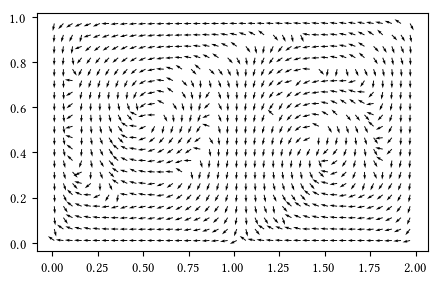

In [414]:
plt.quiver(X[1:-1,1:-1][::5,::5],Y[1:-1,1:-1][::5,::5],vecs[1:-1,1:-1][::5,::5,0,0],vecs[1:-1,1:-1][::5,::5,0,1])

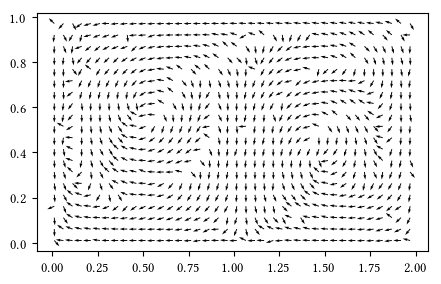

In [415]:
plt.quiver(X[1:-1,1:-1][::5,::5],Y[1:-1,1:-1][::5,::5],evecs[::5,::5,0,0],evecs[::5,::5,0,1])

In [280]:
vecs = vecs.transpose(0,1,3,2)

In [302]:
jac_vel(0,g).shape

(100, 50, 2, 2)

In [258]:
np.max(X)

2.0

In [265]:
a = np.array([[1,2],[3,4]])

In [266]:
a

array([[1, 2],
       [3, 4]])

In [267]:
b = np.array([[5,6],[7,8]])

In [268]:
b

array([[5, 6],
       [7, 8]])

In [269]:
c = np.array([a,b])

In [270]:
c

array([[[1, 2],
        [3, 4]],

       [[5, 6],
        [7, 8]]])

In [271]:
c.shape

(2, 2, 2)

In [273]:
c.transpose(0,2,1)

array([[[1, 3],
        [2, 4]],

       [[5, 7],
        [6, 8]]])

In [283]:
vecs[0,0]

array([[ 0.,  1.],
       [ 1.,  0.]])

In [282]:
evecs[0,0]

array([[-0.85554687,  0.51772536],
       [ 0.51772536,  0.85554687]])

In [277]:
vecs.shape

(400, 200, 2, 2)

In [354]:
vals[0,0]

array([  7.16206789e-18,   1.39625953e+17])

([array([   0.,    1.,    0.,    0.,    0.,    1.,    4.,   11.,   31.,  152.]),
  array([   0.,   80.,  117.,    1.,    0.,    2.,    0.,    0.,    0.,    0.]),
  array([   2.,   79.,  105.,    9.,    3.,    0.,    2.,    0.,    0.,    0.]),
  array([   5.,   56.,  135.,    1.,    1.,    0.,    2.,    0.,    0.,    0.]),
  array([   5.,  132.,   58.,    2.,    1.,    0.,    0.,    2.,    0.,    0.]),
  array([  44.,  123.,   30.,    1.,    0.,    0.,    0.,    2.,    0.,    0.]),
  array([  61.,  116.,   20.,    0.,    1.,    0.,    0.,    2.,    0.,    0.]),
  array([ 72.,  87.,  38.,   1.,   0.,   0.,   0.,   2.,   0.,   0.]),
  array([ 78.,  71.,  43.,   5.,   0.,   1.,   0.,   2.,   0.,   0.]),
  array([ 81.,  59.,  55.,   3.,   0.,   0.,   0.,   0.,   2.,   0.]),
  array([ 83.,  58.,  56.,   1.,   0.,   0.,   0.,   0.,   2.,   0.]),
  array([ 86.,  71.,  39.,   2.,   0.,   0.,   0.,   0.,   2.,   0.]),
  array([ 88.,  74.,  36.,   0.,   0.,   0.,   0.,   0.,   2.,   0.]),
  array

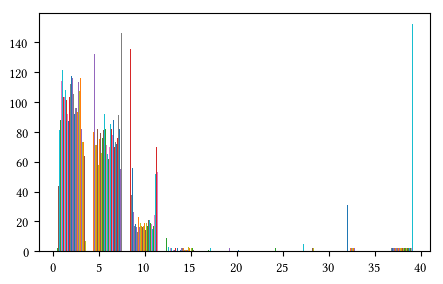

In [362]:
plt.hist(np.log(vals[:,:,1]))

In [397]:
evecs.shape

(198, 98, 2, 2)

In [398]:
vecs.shape

(200, 100, 2, 2)

In [399]:
vecs2 = vecs[1:-1,1:-1]

In [401]:
theta1 = np.arctan2(evecs[:,:,0,1],evecs[:,:,0,0])

In [402]:
theta2 = np.arctan2(vecs2[:,:,0,1],vecs2[:,:,0,0])

In [413]:
np.min(np.abs(theta1)-np.abs(theta2))

-2.2510173875800437

In [411]:
np.pi/180

0.017453292519943295

In [418]:
def f(t,x,eps,w):
    return eps*np.sin(w*t)*x**2+(1-2*eps*np.sin(w*t))*x

In [421]:
f(0.1,0.1,0.1,0.2)

0.09962002533282667

In [429]:
vel(1,np.asarray([1.,2.]))[1]

7.5638660058856002e-17

In [441]:
x,y = np.linspace(0,2,5),np.linspace(0,1,5)
pos = np.array(np.meshgrid(x,y,indexing='ij')).transpose(1,2,0)

In [442]:
pos.shape

(5, 5, 2)

In [445]:
%timeit vel(0,pos)

48.6 µs ± 1.98 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [433]:
A

0.1

In [434]:
eps

0.1

In [435]:
w

0.6283185307179586

In [440]:
vel(0,pos)[0,0,1]

0.0